<a href="https://colab.research.google.com/github/anespart1/educationuse/blob/main/%EC%B9%B4%ED%86%A1%EB%8C%80%ED%99%94%EB%82%B4%EC%97%AD%EC%9C%BC%EB%A1%9C_%EC%82%B4%ED%8E%B4%EB%B3%B4%EB%8A%94_%EC%9A%B0%EB%A6%AC%EC%9D%98_%EC%96%B8%EC%96%B4%EC%82%AC%EC%9A%A9%EC%8B%A4%ED%83%9C_20210906.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#카카오톡 대화내역으로 살펴보는 우리의 언어 사용 실태
본 소스코드는 구글 코랩의 런타임에서 실행되며, 런타임 종료시 사용한 모든 데이터가 소멸됨을 알려드립니다.

##카카오톡 대화내역 가져오는 방법(설명)

<img src="https://t1.daumcdn.net/cfile/tistory/212786405821BBBC0C" width='600' /><br>
출처: [내안의 디지털세상 - 카카오톡 대화 내용 내보내기, 파일로 저장하는 방법](https://prolite.tistory.com/868)

## 한글 자연어처리 패키지 및 관련 함수 작성(숨김)

In [ ]:
!pip install konlpy
import pandas as pd
import re
from konlpy.tag import Hannanum, Kkma, Twitter, Komoran, Mecab # 단어 추출기
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
!wget https://github.com/gshn/fonts/raw/master/NanumSquareRound/NanumSquareRoundR.ttf

--2021-09-05 13:39:17--  https://github.com/gshn/fonts/raw/master/NanumSquareRound/NanumSquareRoundR.ttf
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gshn/fonts/master/NanumSquareRound/NanumSquareRoundR.ttf [following]
--2021-09-05 13:39:18--  https://raw.githubusercontent.com/gshn/fonts/master/NanumSquareRound/NanumSquareRoundR.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1722160 (1.6M) [application/octet-stream]
Saving to: ‘NanumSquareRoundR.ttf.2’

NanumSquareRoundR.t 100%[===================>]   1.64M  --.-KB/s    in 0.04s   

2021-09-05 13:39:18 (36.5 MB/s) - ‘NanumSquareRound

In [ ]:
def remove_numerics(nouns):
  nouns2 = []
  for noun in nouns:
    if not noun.isdigit():
      nouns2.append(noun)
  return nouns2

In [ ]:
def remove_hashtags(words):
  words2 = []
  for word in words:
    if word.startswith('#'):
      words2.append(word[1:])
    else:
      words2.append(word)
  return words2

In [ ]:
def remove_mentions(words):
  words2 = []
  for word in words:
    if word.startswith('@'):
      words2.append(word[1:])
    else:
      words2.append(word)
  return words2

In [ ]:
def remove_others(words):
  words2 = []
  for word in words:
    replaced = re.sub('[-=.,#/?:$}{ ]', '', word.strip())
    words2.append(replaced)
  return words2

In [ ]:
def remove_common_words(word):#필요시 추가 가능
  if word not in word.split():
    return word

In [ ]:
def remove_rare_words(word):
  if word not in rare_words:
    return word

In [ ]:
def kakaochat_to_pandas_df(kakaotext=None, common_words=None):
  with open(kakaotext, "r", encoding="utf-8", errors="", newline="" ) as f:
    lst = f.readlines()
    df = pd.DataFrame(lst)#한번에 pd.read_csv()로 가져오면 에러남... 해당 에러 회피목적
  print('데이터 불러오기 성공')

  df.columns = ['대화내역']
  df['글쓴이'] = df['대화내역'].apply(lambda x: x.split('] [')[0].replace('[', '') if '] [' in x else 'nan')
  df = df[df['글쓴이']!='nan'].copy()
  df['대화당글자수'] = df['대화내역'].apply(lambda x: len(x.replace(' ', '')))
  df['대화당단어수'] = df['대화내역'].apply(lambda x: len(x.split()))
  df['대화평균글자수'] = df['대화당글자수'] / df['대화당단어수']

  #누가 가장 많이 대화에 참여했는가? 
  df1 = df['글쓴이'].value_counts().reset_index()
  df1.columns = ['수다쟁이', '수다횟수']
  chatterbox = df1[df1['수다횟수'] > 1].copy()
  print('대화방 수다쟁이 랭킹 작성 성공')
  
  extractor = Hannanum() # 한글 명사만 골라내기
  print('대화내역 명사 추출 시작...')
  df['명사'] = df['대화내역'].apply(lambda x: extractor.nouns(x))
  print('대화내역 명사 추출 성공')

  df['명사'] = df['명사'].apply(lambda x: x[4:]) # 누가 언제 발언했는지 정보 제외(중복)
  df['명사'] = df['명사'].apply(lambda x: remove_numerics(x))
  df['명사'] = df['명사'].apply(lambda x: remove_hashtags(x))
  df['명사'] = df['명사'].apply(lambda x: remove_mentions(x))
  df['명사'] = df['명사'].apply(lambda x: remove_others(x))
  df['전체명사'] = df['명사'].apply(lambda x: ' '.join(x))
  text_joined = ' '.join(df['전체명사']).split()

  print('대화내역 단어빈도 계산...')
  df_words = pd.DataFrame(text_joined, columns=['단어'])
  df_words['단어'] = df_words['단어'].apply(lambda x: 'ㅋㅋㅋㅋ' if 'ㅋㅋ' in x else x) #웃음표시 하나로 통합
  df_words['단어'] = df_words['단어'].apply(lambda x: 'ㅅㅂ' if x=='시발' else x) #욕설 하나로 통합
  df_words['단어'] = df_words['단어'].apply(lambda x: '가즈아' if x=='가즈' else x) #가즈아 복구
  df_words['단어'] = df_words['단어'].apply(lambda x: '호두과자' if x=='호두과' else x) #호두과자 복구
  df_words['단어'] = df_words['단어'].apply(lambda word: remove_common_words(common_words))
  rare_words = df_words['단어'].value_counts()[df_words['단어'].value_counts() == 1] #한번밖에 안나온 단어
  df_words['단어'] = df_words['단어'].apply(lambda x: remove_rare_words(x))
  df_words.dropna(axis=0, inplace=True)
  df_words['num'] = df_words['단어'].apply(lambda x: len(x))
  df_words = df_words[df_words['num'] > 1].copy()
  df_words.drop(['num'], axis='columns', inplace=True)
  databox = df_words.value_counts().reset_index()
  databox.columns = ['단어', '빈도수']
  print('텍스트마이닝 완료')

  return chatterbox, databox

## 단어빈도, 워드클라우드, 수다쟁이랭킹 만들기(Ctrl+F10)

In [ ]:
#@markdown ### 분석할 대화내역파일 경로를 입력해주세요:
#@markdown URL 또는 런타임 경로도 가능합니다
text_file = "/content/KakaoTalk_20210902_2048_33_942_group.txt" #@param {type:"string"}
#@markdown ### 분석에서 제외할 단어를 입력해주세요:
#@markdown (cf. 오전 오후 메세지 메시지 삭제 샵검색)
common_words = '\uC624\uC804 \uC624\uD6C4 \uBA54\uC138\uC9C0 \uBA54\uC2DC\uC9C0 \uC0AD\uC81C \uC0F5\uAC80\uC0C9' #@param {type:"string"}
chatterbox, databox = kakaochat_to_pandas_df(kakaotext=text_file)

데이터 불러오기 성공
대화방 수다쟁이 랭킹 작성 성공
대화내역 명사 추출 시작...
대화내역 명사 추출 성공
대화내역 단어빈도 계산...
텍스트마이닝 완료


### 단어빈도수 및 수다쟁이 시각화
이모티콘은 이모티콘 사용빈도를 나타냅니다.

In [ ]:
#@markdown ### 단어 빈도를 표현할 순위를 선택해주세요:
#@markdown (cf. 30 = 1위 ~ 30위 단어)
how_many = 30 #@param {type:"slider", min:1, max:100, step:1}
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'xy'}]])
fig.add_trace(go.Pie(labels=chatterbox['수다쟁이'], values=chatterbox['수다횟수'], textinfo='label+percent'), 1, 1)
dtbox = databox.head(how_many).copy(0)
fig.add_trace(go.Bar(x=dtbox['단어'], y=dtbox['빈도수']), 1, 2)
fig.update(layout_showlegend=False)
fig.show()

### 워드클라우드 만들기

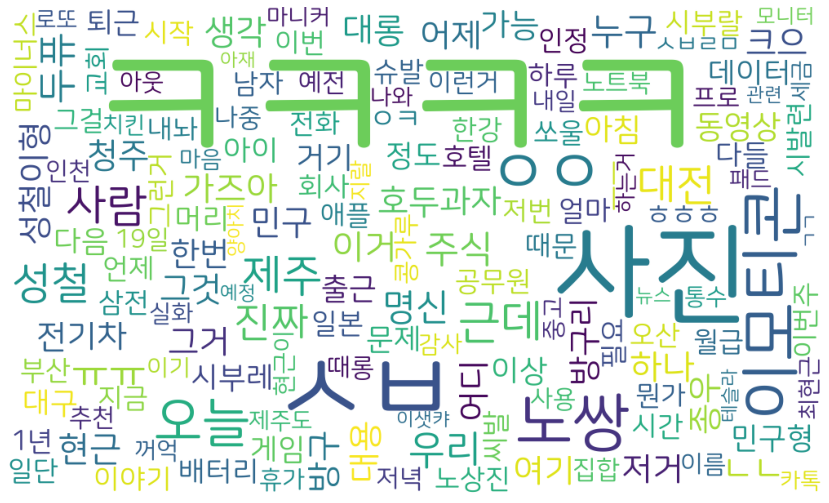

In [ ]:
#@markdown ### 워드클라우드의 크기를 입력해주세요:
#@markdown (cf. 16, 9 = 16:9)
size_width = 16 #@param {type:"slider", min:1, max:21, step:1}
size_height = 9 #@param {type:"slider", min:1, max:12, step:1}
#@markdown ### 워드클라우드에 사용할 단어수를 입력해주세요:
#@markdown (cf. 150 = 빈도순위 1위 ~ 150위까지)
max_words = 150 #@param {type:"slider", min:10, max:200, step:10}
data = dict(zip(databox['단어'].values.tolist(), databox['빈도수'].values.tolist()))
wc = WordCloud(width=1000, height=600, font_path='NanumSquareRoundR.ttf',
               max_words= max_words, min_font_size= 2, background_color='white').generate_from_frequencies(data)
plt.figure(figsize=(size_width, size_height))
plt.imshow(wc)
plt.axis('off')
wc.to_file('word_cloud.png')
plt.show()